# Prédiction des destinations


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tools.metrics import confusion_matrix, cross_validation_score
plt.style.use('seaborn-poster')

## Features engineering


In [5]:
# Import data
users = pd.read_csv('data/train_users_2.csv')
# test_users = pd.read_csv('data/test_users.csv')
sessions = pd.read_csv('data/sessions.csv')

users = users[users['country_destination'] != 'NDF']
users = pd.concat([users[users['country_destination'] == 'US'].head(10000), users[users['country_destination'] != 'US']]).sample(frac=1).reset_index(drop=True)

# Retain users that have a session & add information about their session
sessions_naless = sessions.fillna('_')
sessions['action_name'] = sessions_naless['action'] + '-' + sessions_naless['action_type'] + '-' + sessions_naless['action_detail']
users_sessions = sessions.groupby('user_id').agg({
    "action_name": pd.Series.tolist,
    'secs_elapsed': lambda r: round(r.sum() / (60**2), 0),
})
users_sessions = users_sessions.rename({"secs_elapsed":"hours_elapsed", "action_name":"actions",}, axis=1)
users = users_sessions.reset_index().rename({'user_id':'id'}, axis=1).merge(users, how='right', on='id')
users = users.sort_values('id')

In [6]:
print("users.head : ", users.shape)
users.tail(3)

users.head :  (36532, 18)


,id,actions,hours_elapsed,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
24073,zzulgqh3zm,NaN,NaN,2013-05-30,20130530005442,2013-05-30,FEMALE,38.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,DE
33752,zzv2t56jjo,NaN,NaN,2012-02-15,20120215041554,2012-02-27,-unknown-,NaN,basic,0,en,other,other,NaN,Web,Other/Unknown,-unknown-,US
8678,zzzlylp57e,"[similar_listings-data-similar_listings, show-...",120.0,2014-06-11,20140611074639,2014-06-24,-unknown-,NaN,basic,0,en,seo,google,linked,Web,Windows Desktop,Chrome,FR


In [7]:
# Converting date string into datetime object
users['timestamp_first_active'] = pd.to_datetime(users['timestamp_first_active'], format='%Y%m%d%H%M%S')
users['date_account_created'] = pd.to_datetime(users['date_account_created'], format='%Y-%m-%d')
users["date_first_booking"] = pd.to_datetime(users['date_first_booking'], format='%Y-%m-%d')
users['date_first_active'] = pd.to_datetime(users['timestamp_first_active'].dt.date, format='%Y-%m-%d')
users['hour_first_active'] = users['timestamp_first_active'].dt.hour
users['month_first_active'] = users['date_first_active'].dt.month
users['year_first_active'] = users['date_first_active'].dt.year

In [8]:
def process_age(age):
    if age > 1000:
        return 2015 - age
    elif age == 105:
        return -2
    elif age < 100:
        return age
    else: 
        return -1

# Bucketize age variable
users['age'] = users.apply(lambda r: process_age(r['age']), axis=1)
users['age_group'] = sum([(users['age'] < 0).astype(int),
    (users['age'] < 10).astype(int),
    (users['age'] < 18).astype(int),
    (users['age'] < 25).astype(int),
    (users['age'] < 30).astype(int),
    (users['age'] < 35).astype(int),
    (users['age'] < 40).astype(int),
    (users['age'] < 43).astype(int),
    (users['age'] < 50).astype(int),
    (users['age'] < 60).astype(int),
    (users['age'] < 65).astype(int),
    (users['age'] < 70).astype(int),])

In [9]:
def process_signup_flow(num_page):
    if num_page <= 3:
        return num_page
    elif 3 < num_page < 12:
        return 'middle'
    else:
        return 12
    
# Bucketize signup_flow
users['signup_flow_group'] = users.apply(lambda r: process_signup_flow(r['signup_flow']), axis=1)

In [10]:
# Bucketize language
users['language_group'] = (users['language'] == 'en').astype(int)

In [11]:
# Only retains browser which have a large enough set of users
users_browsers = users.groupby('first_browser').count()[['id']].sort_values(by='id')
browsers = set(users_browsers[users_browsers['id'] > 1000].index)
users['first_browser_processed'] = users.apply(lambda r: r['first_browser'] if r['first_browser'] in browsers else 'Other', axis=1)

In [12]:
# Fill Nan in first_affiliate_tracked
users['first_affiliate_tracked'] = users['first_affiliate_tracked'].fillna('-unknown-')

In [13]:
# # Most use device type (phone or pc)
devices = sessions.groupby('user_id').agg({'device_type': lambda r: r.values.tolist(),}).reset_index().rename({'user_id':'id'}, axis=1)
devices['most_use'] = devices.apply(lambda r: max(set(r['device_type']), key=r['device_type'].count), axis=1)

phones = ['iPhone', 'iPad Tablet', 'Android App Unknown Phone/Tablet', 'Android Phone', 'Tablet', 'Chromebook', 'Blackberry',
          'Windows Phone', 'Opera Phone', 'iPodtouch']
pcs = ['Mac Desktop', 'Windows Desktop', 'Linux Desktop']

def most_use2group(most_use):
    exp = most_use.split('_count')[0]  # Remove _count suffix
    if exp in phones:
        return 'phone'
    elif exp in pcs:
        return 'pc'
    else:
        return '-unknown-'
    
devices['most_use_device_group'] = devices.apply(lambda r: most_use2group(r['most_use']), axis=1)
devices['most_use_device_group'] = devices['most_use_device_group'].fillna('-unknown-')
devices = devices.drop('most_use', axis=1)
users = users.merge(devices, on='id', how='left')

In [14]:
# # Bucketize number of hours elasped
users['hours_elapsed_group'] = sum([(users['hours_elapsed'] < 0).astype(int),
    (users['hours_elapsed'] < 50).astype(int),
    (users['hours_elapsed'] < 100).astype(int),
    (users['hours_elapsed'] < 150).astype(int),
    (users['hours_elapsed'] < 200).astype(int),
    (users['hours_elapsed'] < 250).astype(int),
    (users['hours_elapsed'] < 300).astype(int),
    (users['hours_elapsed'] < 30000000).astype(int),])

In [15]:
# # Bucketize number of unique actions
users['nb_unique_actions'] = users.apply(lambda r: len(set(r['actions'])) if r['actions'] is not np.nan else -1, axis=1)
users['nb_unique_actions_group'] = sum([(users['nb_unique_actions'] < 14).astype(int),
    (users['nb_unique_actions'] < 16).astype(int),
    (users['nb_unique_actions'] < 18).astype(int),
    (users['nb_unique_actions'] < 20).astype(int),
    (users['nb_unique_actions'] < 22).astype(int),
    (users['nb_unique_actions'] < 24).astype(int),(users['nb_unique_actions'] < 240000).astype(int), (users['nb_unique_actions'] < 0).astype(int)])

In [16]:
# relevent_action_names = ['requested-submit-post_checkout_action',
#  'requested-view-p5',
#  'pending-booking_request-pending',
#  'agree_terms_check--unknown---unknown-',
#  'at_checkpoint-booking_request-at_checkpoint',
#  'ajax_photo_widget_form_iframe--unknown---unknown-',
#  'complete_status--unknown---unknown-',
#  'complete_redirect--unknown---unknown-',
#  'travel_plans_current-view-your_trips',
#  'populate_from_facebook--unknown---unknown-',
#  'social_connections-data-user_social_connections',
#  'create-submit-signup',
#  'update-submit-update_listing_description',
#  'manage_listing-view-manage_listing',
#  'set_user-submit-create_listing',
                         
                         
#                          'ajax_refresh_subtotal-click-change_trip_characteristics', 
#  'similar_listings-data-similar_listings', 
                        
                        
#                         ]


relevent_action_names = ['update-submit-update_listing', 'ask_question-submit-contact_host',
       'requested-view-p5', 'show-view-user_profile',
       'pending-booking_request-pending',
       'search_results-click-view_search_results',
       'confirm_email-click-confirm_email_link',
       'show_personalize-data-user_profile_content_update',
       'identity--unknown---unknown-', 'create-submit-create_phone_numbers',
       'active--unknown---unknown-', 'dashboard-view-dashboard',
       'other_hosting_reviews_first--unknown---unknown-',
       'requested-submit-post_checkout_action', 'create-submit-create_user']

# Encode actions
one_hot_encoded_actions = pd.get_dummies(sessions[sessions['action_name'].isin(relevent_action_names)][['user_id', 'action_name']], columns=['action_name'])

# Generate functions for aggretation
columns = one_hot_encoded_actions.columns.values.tolist()
columns.remove('user_id')
agg_funcs = {col_name: sum for col_name in columns}

# Aggretate actions by users
actions_matrix = one_hot_encoded_actions.groupby('user_id').agg(agg_funcs)

# Selecting the most relevent columns
cols = ['action_name_' + name for name in relevent_action_names]
mat = (actions_matrix[cols].div(actions_matrix[cols].sum(axis=1), axis=0).fillna(0) * 10).astype(int)
mat.head(3)

,action_name_update-submit-update_listing,action_name_ask_question-submit-contact_host,action_name_requested-view-p5,action_name_show-view-user_profile,action_name_pending-booking_request-pending,action_name_search_results-click-view_search_results,action_name_confirm_email-click-confirm_email_link,action_name_show_personalize-data-user_profile_content_update,action_name_identity--unknown---unknown-,action_name_create-submit-create_phone_numbers,action_name_active--unknown---unknown-,action_name_dashboard-view-dashboard,action_name_other_hosting_reviews_first--unknown---unknown-,action_name_requested-submit-post_checkout_action,action_name_create-submit-create_user
user_id,,,,,,,,,,,,,,,
00023iyk9l,0,0,4,0,0,0,0,0,0,0,0,3,0,0,0
0010k6l0om,0,0,0,0,0,8,0,0,0,0,0,2,0,0,0
001wyh0pz8,0,0,0,3,0,0,0,0,0,0,6,0,0,0,0


In [17]:
# action_names = ['ajax_refresh_subtotal-click-change_trip_characteristics', 
#  'similar_listings-data-similar_listings', 
#  'pending-booking_request-pending', 'requested-submit-post_checkout_action',
#  'requested-view-p5',
#  'agree_terms_check--unknown---unknown-',
#  'at_checkpoint-booking_request-at_checkpoint',
#  'ajax_photo_widget_form_iframe--unknown---unknown-',
#  'complete_status--unknown---unknown-']

# for name in action_names:
#     users[f'did_{name}'] = users.apply(lambda r: 1 if r['actions'] is not np.nan and name in r['actions'] else 0, axis=1)

In [18]:
users_final = users.merge(mat.round(0).reset_index().rename({'user_id':'id'}, axis=1), how='left', on='id').fillna(0)
# users_final = users

# # Selecting features
# features = ['year_first_active', 'hour_first_active', 'month_first_active', 'gender', 'age_group', 'signup_method', 'signup_flow_group',  'affiliate_provider', 
#            'signup_app', 'first_browser_processed', 'language', 'affiliate_channel', 'first_device_type',
#            'hours_elapsed_group', 'nb_unique_actions_group', 'most_use_device_group']

features = ['year_first_active', 'hour_first_active', 'month_first_active', 'gender', 'age_group', 'signup_method', 'signup_flow_group',  'affiliate_provider', 
           'signup_app', 'first_browser_processed', 'language', 'affiliate_channel', 'first_device_type', 'first_affiliate_tracked',
           ]

features += ['action_name_' + name for name in relevent_action_names]
# features += [f'did_{name}' for name in action_names]

data = users_final[features].copy()

X = pd.DataFrame()
for feature in features:
    X[feature] = data[feature].astype('category').cat.codes
X = X.values
y = users_final['country_destination'].values
print(data.shape, X.shape)

(36532, 29) (36532, 29)


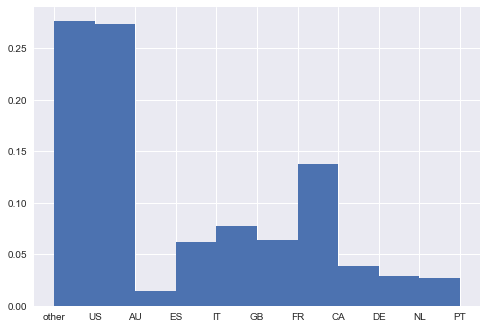

In [19]:
users['country_destination'].hist(density=True)

## Training model

In [20]:
from tools.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
# from tools.forest import RandomForestClassifier

# Weights inverted for conter-balancing

weights = {c:1-y.tolist().count(c)/y.shape[0] for c in np.unique(y)}
model = RandomForestClassifier(n_estimators=100, max_depth=15, class_weight='balanced_subsample')

# model = RandomForestClassifier(n_estimators=50, max_depth=15)
res = cross_validation_score(model, X, y, k=5)
print(f"Mean score : {round(np.mean(res), 4)}")
print(f"Std score : {round(np.std(res), 5)}")

Mean score : 0.4277
Std score : 0.00687


0.6112163048494831


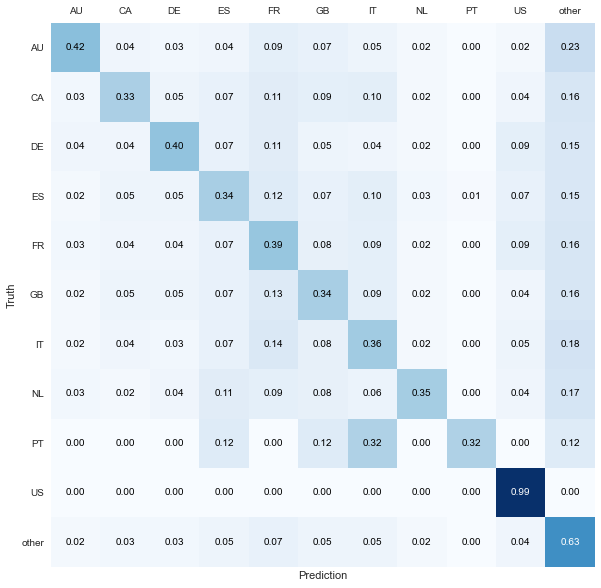

In [21]:
def dcg(destinations, truth):
    arr = (np.array(destinations) == truth).astype(int)
    return np.sum(((2 ** arr) - 1) / np.log2(np.arange(arr.shape[0]) + 2))

def ndcg(destinations, truth):
    t = destinations.count(truth)
    a = [truth if i < t else '-' for i in range(len(destinations))]
    max_dcg = dcg(a, truth)
    max_dcg = max_dcg + 1 if max_dcg == 0 else max_dcg
    return dcg(destinations, truth) / max_dcg

def confusion_matrix_ndcg(y_pred, y, plot=True, normalize=True, decimal=2, figsize=(10, 10)):
    labels = np.unique(y)
    counts = np.zeros((labels.shape[0], labels.shape[0]))
    for prediction, truth in zip(y_pred, y):
        i_truth = np.where(labels == truth)[0][0]
        for pred in prediction:
            i_prediction = np.where(labels == pred)[0][0]
            counts[i_truth][i_prediction] += ndcg(prediction, truth)
            if pred == truth: break

    # Normalize
    if normalize:
        counts = np.round(counts / np.sum(counts, axis=1).reshape(counts.shape[0], 1), decimal)

    if plot:
        fig, ax = plt.subplots(figsize=figsize)
        ax.grid(False)
        ax.matshow(counts, cmap=plt.cm.Blues)
        ax.set_ylabel('Truth')
        ax.set_xlabel('Prediction')
        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_xticklabels(labels.tolist())
        ax.set_yticklabels(labels.tolist())

        for (i, j), z in np.ndenumerate(counts):
            color = 'black' if counts[i][j] <= 0.5 or not normalize else 'white'
            ax.text(j, i, f'{{:0.{decimal}f}}'.format(z), ha='center', va='center', c=color)
    return counts

n = int(X.shape[0] * 0.7)
model.fit(X[:n], y[:n])
pred_probas = model.predict_proba(X[n:])
idx = np.argsort(-pred_probas)[:,:5]

def probas2pred(idsort, model):
    return [model.classes_[i] for i in idsort]

df = pd.DataFrame()
df['country_destination'] = [probas2pred(idsort, model) for idsort in idx]
df['true_destination'] = y[n:]
df['ndcg'] = df.apply(lambda r: ndcg(r['country_destination'], r['true_destination']), axis=1)
print(df['ndcg'].mean())

_ = confusion_matrix_ndcg(df['country_destination'].values, df['true_destination'], plot=True, normalize=True)

In [22]:
df

,country_destination,true_destination,ndcg
0,"[other, ES, GB, NL, FR]",other,1.000000
1,"[other, FR, GB, DE, NL]",other,1.000000
2,"[US, ES, other, CA, FR]",US,1.000000
3,"[US, IT, ES, DE, FR]",US,1.000000
4,"[other, FR, IT, GB, ES]",CA,0.000000
...,...,...,...
10955,"[other, FR, CA, IT, GB]",GB,0.386853
10956,"[other, AU, FR, GB, DE]",other,1.000000
10957,"[other, FR, CA, AU, GB]",DE,0.000000
10958,"[US, GB, other, ES, DE]",US,1.000000


In [23]:
# Worst case
dummy = pd.DataFrame()
dummy['true_destination'] = y[n:]
dummy['country_destination'] = [['US', 'other', 'FR', 'IT', 'GB'] for _ in y[n:]]
dummy['ndcg'] = dummy.apply(lambda r: ndcg(r['country_destination'], r['true_destination']), axis=1)
dummy['ndcg'].mean()

0.5707538177234929

In [60]:
import folium
from folium.features import DivIcon

i = -2
truth = y[i]
print("Expected label", truth)
u = X[i]
print(u)
probas = {}
for proba, country in zip(model.predict_proba([u])[0], model.classes_):
    probas[country] = proba

coords = {
    'FR': (46, 2),
    'US': (40, -103),
    'CA': (55, -110),
    'PT': (41, -9),
    'ES': (37, -2),
    'AU': (-35, 149),
    'DE': (49, 10),
    'IT': (41, 12),
    'GB': (55, -2),
    'NL': (52, 5),
}

f = folium.Figure(width=1100, height=600)
fmap = folium.Map([30, 0], zoom_start=2, scrollWheelZoom=False,).add_to(f)
topfive = sorted(probas, key=lambda x: probas[x], reverse=True)[:8]
print(topfive)

for country in coords:
    if country not in topfive: continue
    prob = coords[country][0]
    folium.Circle(
        [coords[country][0], coords[country][1]],
        1400000*probas[country], fill=True, 
        color='red' if country == truth else 'blue').add_child(folium.Popup(f'Probabilité : {probas[country]}')).add_to(fmap)
    folium.map.Marker(
        [coords[country][0]+0.5, coords[country][1]-1.6],
        tooltip=f'{country}\n avec proba {round(probas[country], 3)}',
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 9pt">{country}\n{round(probas[country], 3)}</div>',
            ),
        ).add_to(fmap)
fmap

Expected label US
[ 3  4  1  0 12  0  0 12  2  0  4  3  4  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]
['US', 'GB', 'other', 'ES', 'DE', 'IT', 'FR', 'CA']
